### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2025 Semester 2

## Assignment 1

**Student Name:**    `YU LUO`

**Student ID:**     `1528667`

This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Draw wireframe cube from (x,y) points
def draw_cube(pts):

    # plot points
    plt.figure()
    plt.plot(pts[:, 0], pts[:, 1], 'k.')

    # define edges
    edges = np.array([
        [0, 1], [2, 3], [0, 2], [1, 3],
        [4, 5], [6, 7], [4, 6], [5, 7],
        [0, 4], [1, 5], [2, 6], [3, 7]
    ])

    # plot edges
    for edge in edges:
        plt.plot(pts[edge, 0], pts[edge, 1], 'k-')  # plot lines between connected edges

    # crop to sensor area (24 x 36 mm)
    plt.axis('equal')
    plt.xlim([-18, 18])
    plt.ylim([-12, 12])
    plt.show()

### 1. Mapping between world and image coordinates

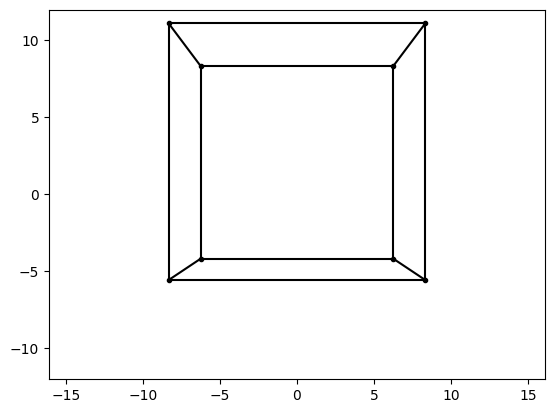

In [2]:
# corners of the cube in the image
xy_image = np.array([[-8.333333, -5.555556],
                     [8.333333, -5.555556],
                     [-8.333333, 11.11111],
                     [8.333333, 11.11111],
                     [-6.25, -4.166667],
                     [6.25, -4.166667],
                     [-6.25, 8.333333],
                     [6.25, 8.333333]])

# draw the cube
draw_cube(xy_image)

#### 1.1 Compute the world coordinates

In [8]:

# Camera / scene parameters (mm)
f = 50.0
Z_front = 900.0
s = 300.0
Z_back = Z_front + s

# According to the setup, first 4 are the front face, last 4 are the back face
Z = np.array([Z_front]*4 + [Z_back]*4, dtype=float)

# Vectorised inverse projection: X = x*Z/f, Y = y*Z/f
X = xy_image[:, 0] * Z / f # Recover all the X_World coordinates
Y = xy_image[:, 1] * Z / f # Recover all the Y_World coordinates

# Stack all individual coordinates back to 3D format
coords_world = np.column_stack([X, Y, Z])

# Labels matching the corner order:
corner_labels = [
    "F_BL", "F_BR", "F_TL", "F_TR",
    "B_BL", "B_BR", "B_TL", "B_TR"
]

# Print out all corners coordinates in a table
print(f"{'Corner':<6} | {'X (mm)':>8} {'Y (mm)':>9} {'Z (mm)':>9}")
print("-"*40)
for lbl, (xw, yw, zw) in zip(corner_labels, coords_world):
    print(f"{lbl:<6} | {xw:8.0f} {yw:9.0f} {zw:9.0f}")


Corner |   X (mm)    Y (mm)    Z (mm)
----------------------------------------
F_BL   |     -150      -100       900
F_BR   |      150      -100       900
F_TL   |     -150       200       900
F_TR   |      150       200       900
B_BL   |     -150      -100      1200
B_BR   |      150      -100      1200
B_TL   |     -150       200      1200
B_TR   |      150       200      1200


#### 1.2 Write code to convert world coordinates to image coordinates and translate the cube in the world

##### 1.2.1 Convert world coordinates

In [18]:
import numpy as np

# -------------------------------
# Camera / scene parameters (mm)
# -------------------------------
f = 50.0               # focal length (mm)
Z_front = 900.0        # Z of the front face (mm)
side = 300.0           # cube side length (mm)
Z_back  = Z_front + side

# ----------------------------------------------------
# 1) Retrieve the cube in WORLD coordinates from our calculation
# ----------------------------------------------------
# Order: F_BL, F_BR, F_TL, F_TR, B_BL, B_BR, B_TL, B_TR (8x3)
cube_world = coords_world

# ----------------------------------------------------
#    World -> Image (pinhole)
#    Input: Pw (...,3) in mm, camera at origin, looking +Z
#    Output: pi (...,2) image coords (mm)
#    Formula: x = f * X/Z,  y = f * Y/Z
# ----------------------------------------------------
def world_to_image(Pw, f_mm):
    """
    Vectorised pinhole projection from world (mm) to image plane (mm).

    Projects 3D world coordinates (X, Y, Z) onto the 2D image plane (x, y)
    using the pinhole camera model. The camera is assumed to be at the
    origin (0, 0, 0) looking along the positive Z-axis.

    Parameters
    ----------
    Pw : ndarray (..., 3)
        World coordinates [X, Y, Z] in millimetres.
        Can be a single point (3,) or multiple points (N, 3), etc.
    f_mm : float
        Focal length of the camera in millimetres.

    Returns
    -------
    pi : ndarray (..., 2)
        Image coordinates [x, y] in millimetres.
        The shape matches the input Pw, but with the last dimension
        reduced from 3 to 2.
    """
    # Extract X, Y, and Z coordinates from the input array
    X = Pw[..., 0]
    Y = Pw[..., 1]
    Z = Pw[..., 2]


    # Prevent division by zero or projection of points behind the camera (Z <= 0)

    # Solution: Replacing Z values less than or equal to a small epsilon with epsilon
    # if it is at the camera (Z=0) or even behind the camera (Z<0)
    # to avoid errors and push points very far away
    eps = 1e-9
    Z_safe = np.maximum(Z, eps) # In our setup, it will always choose the normal Z as it is positive

    # Apply the pinhole projection formula: x = f * X / Z and y = f * Y / Z
    x = f_mm * X / Z_safe
    y = f_mm * Y / Z_safe

    # Stack the resulting x and y coordinates to form the 2D image points
    return np.stack([x, y], axis=-1)


In [19]:
# Convert to image plane using our calcualted world coordinates
xy_image_new = world_to_image(cube_world, f)

print(f"{'Corner':<6} | {'x (mm)':>10} {'y (mm)':>10}")
print("-"*40)
for lbl, (xw, yw) in zip(corner_labels, xy_image_new):
    print(f"{lbl:<6} | {xw:10.6f} {yw:10.6f}")

Corner |     x (mm)     y (mm)
----------------------------------------
F_BL   |  -8.333333  -5.555556
F_BR   |   8.333333  -5.555556
F_TL   |  -8.333333  11.111110
F_TR   |   8.333333  11.111110
B_BL   |  -6.250000  -4.166667
B_BR   |   6.250000  -4.166667
B_TL   |  -6.250000   8.333333
B_TR   |   6.250000   8.333333


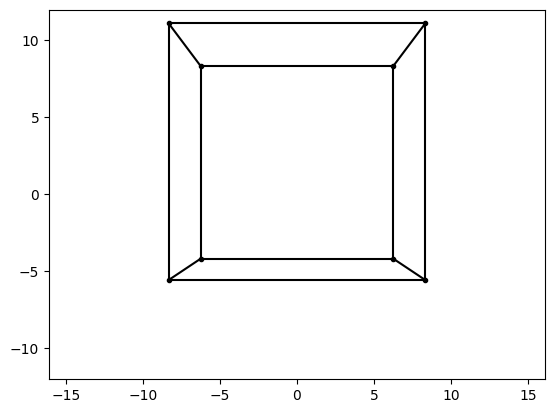

In [20]:
draw_cube(xy_image_new) # Shows the cube using the converted coordinates to see if it matches original

##### 1.2.2 Translate the cube in the world

In [21]:
def translate_world(Pw, t):
    """
    Translate world coordinates by a 3D vector t (mm).

    Adds a constant translation vector `t` to each 3D point in `Pw`.

    Parameters
    ----------
    Pw : ndarray (N, 3)
        World coordinates. Can be a single point or multiple points.
    t  : array-like (3,)
        Translation vector [dX, dY, dZ] in mm.

    Returns
    -------
    Pw_translated : ndarray (N, 3)
        Translated world coordinates.
    """
    # Ensure the translation vector is a numpy array and has the correct shape
    t = np.asarray(t, dtype=float).reshape(1, 3)
    # Add the translation vector to the world coordinates
    return Pw + t

##### 1.2.3 Verify the translation

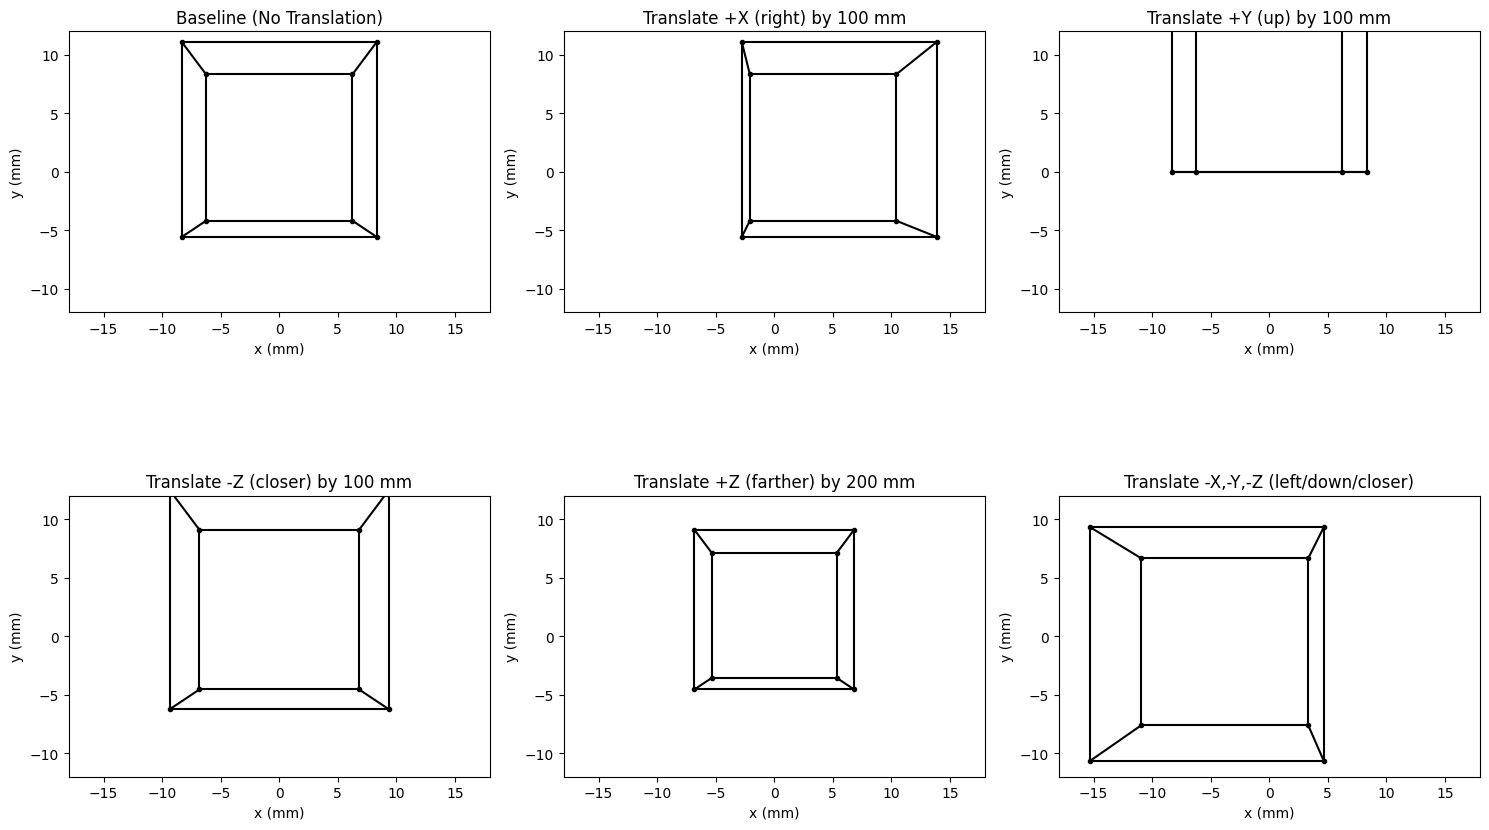

In [43]:
# New helper function to display cube in the image plane on specific plt axes
def draw_cube_subplot(ax, pts):
    """
    Draw a wireframe cube on a specific matplotlib Axes object.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes to draw the cube on.
    pts : ndarray (8, 2)
        The 2D image coordinates of the cube's vertices.
    """
    # plot points
    ax.plot(pts[:, 0], pts[:, 1], 'k.')

    # define edges
    edges = np.array([
        [0, 1], [2, 3], [0, 2], [1, 3],
        [4, 5], [6, 7], [4, 6], [5, 7],
        [0, 4], [1, 5], [2, 6], [3, 7]
    ])

    # plot edges
    for edge in edges:
        ax.plot(pts[edge, 0], pts[edge, 1], 'k-')

    # crop to sensor area (24 x 36 mm)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim([-18, 18])
    ax.set_ylim([-12, 12])
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')


def project_and_draw_cube(ax, Pw, f, title):
    """
    Projects world coordinates to image coordinates and draws the cube on a subplot.
    """
    image_coords = world_to_image(Pw, f)
    draw_cube_subplot(ax, image_coords)
    ax.set_title(title)



# Set up a figure with multiple subplots to show all transformations at once.
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# (a) No translation (baseline)
project_and_draw_cube(axes[0], cube_world, f, "Baseline (No Translation)")

# (b) Move RIGHT by +100 mm in world (X direction) -> image x should shift right
Pw_right = translate_world(cube_world, t=[+100.0, 0.0, 0.0])
project_and_draw_cube(axes[1], Pw_right, f, "Translate +X (right) by 100 mm")

# (c) Move UP by +100 mm in world (Y direction) -> image y should shift up
Pw_up = translate_world(cube_world, t=[0.0, +100.0, 0.0])
project_and_draw_cube(axes[2], Pw_up, f, "Translate +Y (up) by 100 mm")

# (d) Move CLOSER by -100 mm in world (Z direction) -> image should get larger
Pw_closer = translate_world(cube_world, t=[0.0, 0.0, -100.0])
project_and_draw_cube(axes[3], Pw_closer, f, "Translate -Z (closer) by 100 mm")

# (e) Move FARTHER by +200 mm in world (Z direction) -> image should get smaller
Pw_farther = translate_world(cube_world, t=[0.0, 0.0, +200.0])
project_and_draw_cube(axes[4], Pw_farther, f, "Translate +Z (farther) by 200 mm")

# (f) A combined translation (left, down, closer)
Pw_combo = translate_world(cube_world, t=[-80.0, -60.0, -150.0])
project_and_draw_cube(axes[5], Pw_combo, f, "Translate -X,-Y,-Z (left/down/closer)")

plt.tight_layout()
plt.show()

### 2. Depth of field simulation

In [49]:
!unzip /content/COMP90086_asst1_2025_images.zip

Archive:  /content/COMP90086_asst1_2025_images.zip
  inflating: OldQuad.jpg             
  inflating: OldQuad-depth.png       
  inflating: OWeek.jpg               
  inflating: OWeek-depth.png         


In [48]:
# Example image
img = 'OWeek.jpg'
z_world = 'OWeek-depth.png' # Z_world in mm
f = 28 # focal length in mm

# Example image
img = 'OldQuad.jpg'
z_world = 'OldQuad-depth.png' # Z_world in mm
f = 24 # focal length in mm

# sensor width/height in mm
h_sensor = 24
w_sensor = 36

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 # You will need to install this library: pip install opencv-python

def simulate_depth_of_field(img_path, depth_map_path, f, h_sensor, w_sensor, focal_plane_z, blur_strength=15):
    """
    Simulates a low depth of field effect based on a depth map.

    Parameters
    ----------
    img_path : str
        Path to the original image file.
    depth_map_path : str
        Path to the depth map image file. The values are Z_world in mm.
    f : float
        Focal length of the camera in mm.
    h_sensor : float
        Height of the camera sensor in mm.
    w_sensor : float
        Width of the camera sensor in mm.
    focal_plane_z : float
        The Z-distance (in mm) of the focal plane, i.e., the distance of the
        objects that will be in sharp focus.
    blur_strength : int, optional
        The strength of the Gaussian blur. A higher value means more blur.

    Returns
    -------
    ndarray
        The resulting image with simulated depth of field.
    """
    # 1. Load the images
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Translate the BGR channel to RGB

    # The depth map is provided with Z_world values in mm
    z_world_map = cv2.imread(depth_map_path, cv2.IMREAD_UNCHANGED)

    if z_world_map.dtype == np.uint8:
        # Assuming the depth map is grayscale and normalized to 0-255
        # The assignment says the values are Z_world in mm, so we'll assume a
        # different loading method might be needed or a conversion based on min/max
        # depth values. For now, let's assume it's loaded as is.
        print("Warning: Depth map is 8-bit. Assuming a proper conversion is handled outside this function.")
        # For demonstration purposes, let's scale it if necessary.
        # This part may need to be adjusted based on how the png stores depth values.

    H, W = z_world_map.shape[:2]

    # 2. Compute a simple focal mask based on Z_world
    # You can choose a tolerance for what is considered "in focus"
    tolerance = 50 # 50 mm around the focal plane
    in_focus_mask = np.abs(z_world_map - focal_plane_z) < tolerance

    # 3. Apply a Gaussian blur to the entire image
    # The kernel size should be an odd number
    ksize = (blur_strength, blur_strength)
    blurred_img = cv2.GaussianBlur(img, ksize, 0)

    # 4. Replace in-focus pixels with the original, unblurred values
    result_img = np.where(np.stack([in_focus_mask] * 3, axis=-1), img, blurred_img)

    return result_img


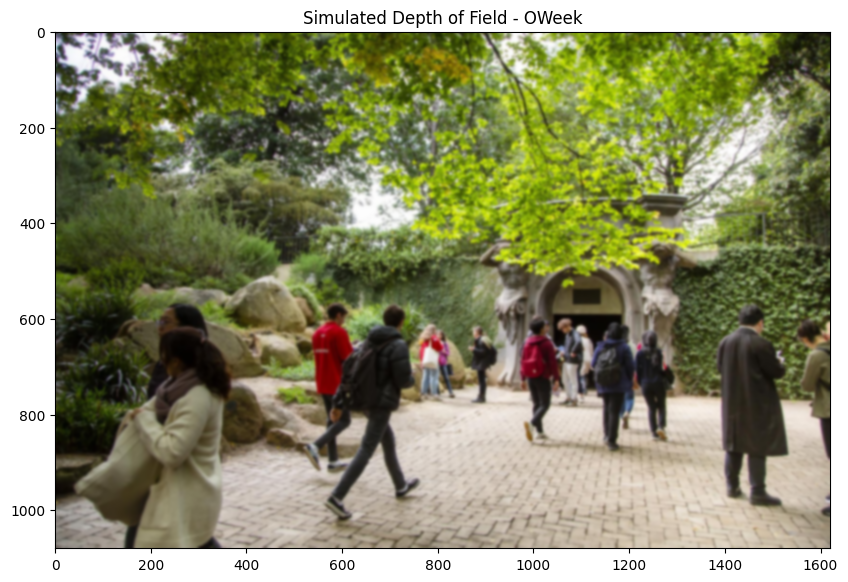

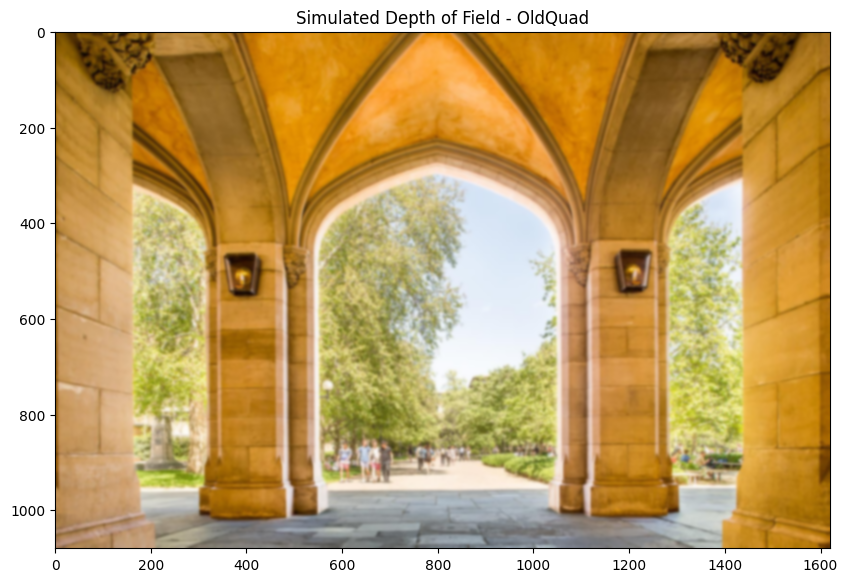

In [52]:

# Example usage for the provided images in the notebook template
# The specific image files are not provided, so these are placeholders.
# Use your provided images for these paths.

# Example 1: OWeek image
img_oweek = 'OWeek.jpg'
z_world_oweek = 'OWeek-depth.png'
f_oweek = 28.0
h_sensor = 24.0
w_sensor = 36.0
focal_plane_oweek = 15000.0 # Example focal distance in mm

result_oweek = simulate_depth_of_field(img_oweek, z_world_oweek, f_oweek, h_sensor, w_sensor, focal_plane_oweek)
plt.figure(figsize=(10, 8))
plt.imshow(result_oweek)
plt.title("Simulated Depth of Field - OWeek")
plt.show()

# Example 2: OldQuad image
img_oldquad = 'OldQuad.jpg'
z_world_oldquad = 'OldQuad-depth.png'
f_oldquad = 24.0
h_sensor = 24.0
w_sensor = 36.0
focal_plane_oldquad = 20000.0 # Example focal distance in mm

result_oldquad = simulate_depth_of_field(img_oldquad, z_world_oldquad, f_oldquad, h_sensor, w_sensor, focal_plane_oldquad)
plt.figure(figsize=(10, 8))
plt.imshow(result_oldquad)
plt.title("Simulated Depth of Field - OldQuad")
plt.show()